In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.constants as c
import astropy.units as u

from mpl_toolkits.axes_grid1 import make_axes_locatable

try:
    from colossus.cosmology import cosmology
    from colossus.lss.mass_function import massFunction
    # Documentation for Colossus mass fcn models
    # https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#mass-function-models
    # Example notebook
    # https://bdiemer.bitbucket.io/colossus/_static/tutorial_lss_mass_function.html 
    # Someone did it manually: https://stackoverflow.com/questions/31818448/defining-and-plotting-a-schechter-function-plot-problems
except Exception as e:
    print('%s: Mass function cells won\'t work'%e)
    
try:
    import camb
except Exception as e:
    print(e)

#### <span id='top'>Sections<span/>:

1. [Calculation of Tremaine-Gunn limit for multicomponent DM](#TrG)
2. [Calculation of $\lambda_{CDM}$, WDM, FDM using Colossus](#MFcn)
3. [Testing with CAMB](#CAMB)

---
### <span id="TrG">Tremaine-Gunn Limit for Multicomponent DM</span>

This will be a bit of an order-of-magnitude approach, since the units are finicky.

[]

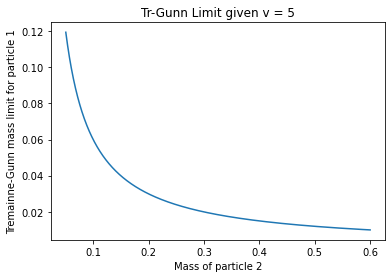

In [2]:
"""
Masses will be ~.1 to .5 keV
vel_disp ~ 3 to 10 km/s
r_c ~ 100 to 400 pc
"""

# Fix this to properly represent order of magnitude
G = 1000#c.G
hbar = 2#c.hbar

def mass_limit(mass2, velocity_dispersion, central_radius):
	m4 = mass2
	v = velocity_dispersion
	r = central_radius
	C = (2 * np.pi)**(3/2) * 4 * G / (9 * hbar**2)
	return ( (C * v * r**2)**(-0.25) ) * (1/m4)

# Tr.Gunn lim vs. Mass plot
fig, ax = plt.subplots()

m = np.linspace(.05,.6,1000)# *u.keV
v = 5# *u.km/u.s
r_c = 300# *u.pc

ax.plot(m, mass_limit(m, v, r_c), label = 'variable mass')
ax.set_ylabel('Tremainne-Gunn mass limit for particle 1')
ax.set_xlabel('Mass of particle 2')
ax.set_title('Tr-Gunn Limit given v = %s'%v)
plt.plot()
#fig.savefig('variable_mass.png')

[]

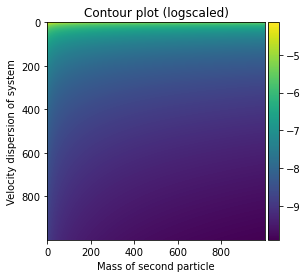

In [3]:
# Contour Plot
fig, ax = plt.subplots()
m = np.linspace(1,100,1000)
v = np.linspace(.1,10,1000)
r_c = 300

mt = np.zeros(1000*1000).reshape(1000,1000)


for i,m0 in enumerate(m):
    for j,v0 in enumerate(v):
        try:
            mt[i][j] = mass_limit(m0,v0,r_c)
        except:
            print(i)
            print(j)

ax.set_xlabel('Mass of second particle')
ax.set_ylabel('Velocity dispersion of system')

im = ax.imshow(np.log(mt) )
#from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_title('Contour plot (logscaled)')
plt.plot()
#fig.savefig('Contour-plot.png')

/home/xavier/miniconda3/envs/threeML_ebl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


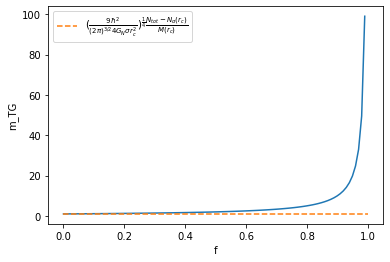

In [4]:
fig, ax = plt.subplots()
f = np.linspace(0,1,100)
mTG = lambda f: 1/(1-f)
ax.plot(f, mTG(f))
ax.set_xlabel('f')
ax.set_ylabel('m_TG')
plt.tick_params(axis='y',
        labelbottom=False)
ax.plot(f,np.ones(len(f)), '--',label = r'$(\frac{9\hbar^2}{(2\pi)^{3/2} 4 G_N\sigma r^2_c})^{\frac{1}{4}} \frac{N_{tot} - N_\alpha(r_c)}{M(r_c)}$')
ax.legend()

plt.show()
#fig.savefig('fvsm_TG.png')

---
[Go to Top](#top)

### <span id="MFcn">Mass Fcn using Colossus</span>

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


[]

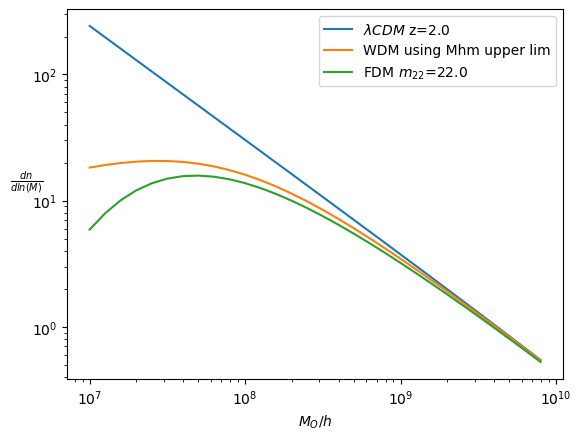

In [2]:
# Set cosmology model
cosmology.setCosmology('planck15')
print(cosmology.getCurrent())

# Mass range :: 10^7 to 10^10 M_solar
M = 10**( np.arange(7., 10., 0.1) )
z = 2.

fig, ax = plt.subplots()

# massFunction -- model = 'press74'
ax.plot(M,
        massFunction( M, z, q_in='M', q_out='dndlnM', model='press74' ),
    label = r'$\lambda CDM$ z=%s'%z)


# https://arxiv.org/pdf/2001.05503.pdf
# WDM : (dN/dlnM)[WDM] = (1+ M_(hm)/M)^(-B) (dN/dlnM)[CDM]
#   B = 1.3
#   Mhm (upper limit) = 6.3 x 10^7 M_0
def WDM(M, z, Mhm = 6.3 * 10**7, beta=1.3):
    return (1 + (Mhm / M) )**(-beta) * massFunction(M, z, q_in='M', q_out='dndlnM', model='press74')

ax.plot(M, WDM(M, z), label = 'WDM using Mhm upper lim')

# FDM : (dN/dlnM)[FDM] = f1(M) + f2(M)(dN/dlnM)[CDM]
#   f1(M) = B exp[-(ln(M / M1 x 10^8 M_0 )^2 / sigma)]
#   f2(M) = [1 + (M / M2 x 10^8 M_0)^(-alpha1)]^(-10/alpha1)
#       alpha1 = 0.72
#       sigma = 1.4
#       M1/m22^-1.5 = 4.7
#       M2/m22^-1.6 = 2.0
#       beta/m22^-1.5 = .014
m22 = 22.
def FDM(M, z, alpha=0.72, sigma=1.4,
        M1 = m22**(-1.5) * 4.7,
        M2 = m22**(-1.5) * 2. ,
        beta = m22**(-1.5) * .014):
    f1 = beta * np.exp( 
            -1 * np.log(
                M / (M1 * 10**8) 
                )**2 / sigma )
    f2 = (1 + (
        M / (M2 * 10**8) )**(-alpha) )**(-10/alpha)
    return f1 + f2*massFunction(M, z, q_in='M', q_out='dndlnM', model='press74')

ax.plot(M, FDM(M, z), label = r'FDM $m_{22}$=%s'%m22)

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{O}/h$')
ax.set_ylabel(r'$\frac{dn}{d ln(M)}$', rotation='horizontal')

plt.plot()

#fig.savefig('massfcn.png')

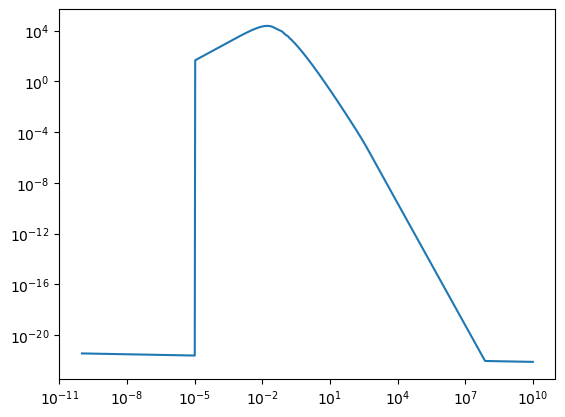

In [30]:
transfer_fcn = cosmology.power_spectrum.powerSpectrum

k = np.logspace(-10,10,1000)

tf = transfer_fcn(k, model = 'camb', cosmo = cosmology.getCurrent(), output='ps')

plt.loglog(k, tf)

---

[Go to Top](#top)

### <span id="CAMB">CAMB</span>

Can install simply by using favored environment & using: `pip install camb`


##### Useful links

[CAMB ReadTheDocs: Transfer variables](https://camb.readthedocs.io/en/latest/transfer_variables.html)

<a href="https://cluster-toolkit.readthedocs.io/en/latest/source/massfunction.html">Cluster Toolkit Halo Mass Fcn (dep. on CAMB)</a>


##### Installing the Fortran version of CAMB/axionCAMB

1. Install [gfortran](https://gcc.gnu.org/wiki/GFortranBinaries) (or some other compiler for fortran)
2. Clone the fortran CAMB and axionCAMB repositories:

> `git clone https://github.com/dgrin1/axionCAMB.git axionCAMB/`

> `git clone --recurse-submodules https://github.com/cmbant/CAMB.git CAMB/`

3. Go to CAMB/fortran and run `make`, then `./camb ../inifiles/params.ini`
4. Go to axionCAMB and `cp MakeFileCAMB MakeFile`
5. *Assuming that you have gfortran* `vi MakeFile` and modify:

> `12: #F90C     = ifort`

> `13: #FFLAGS= -O3`

> `...`

> `26: F90C     = gfortran -ffast-math`

> `27: FFLAGS =  -O2`

6. Then run `make` in the axionCAMB directory.

In [16]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122) # I don't really understand what these params mean.

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022
 omch2 = 0.122
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.5
 TCMB = 2.7255
 YHe = 0.24524332588411976
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 

In [17]:
# First, we go about computing the \lambda CDM matter power spectrum for the linear and nonlinear cases.
pars.set_matter_power(redshifts=[1], kmax=100.)
results = camb.get_results(pars)
kh, z, PK_linear = results.get_matter_power_spectrum(minkh = 1e-4, maxkh=100., npoints = 200)

pars.NonLinear = camb.model.NonLinear_both
results = camb.get_results(pars)
results.calc_power_spectra(pars)

kh, z, PK = results.get_matter_power_spectrum(minkh = 1e-4, maxkh=100., npoints = 200)

In [19]:
pars

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_both
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 100.0
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [1.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022
 omch2 = 0.122
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.5
 TCMB = 2.7255
 YHe = 0.24524332588411976
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 

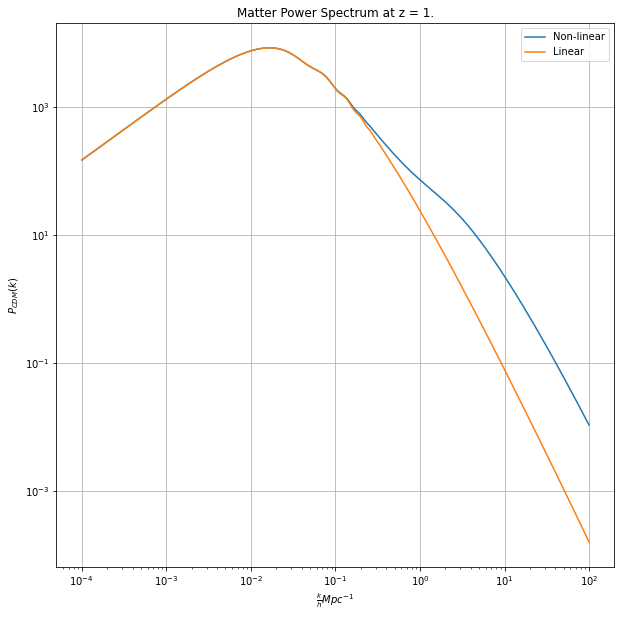

In [18]:
fig,ax=plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.plot(kh, PK[0], label = "Non-linear")
ax.plot(kh, PK_linear[0], label = "Linear")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\frac{k}{h} Mpc^{-1}$')
ax.set_ylabel(r'$P_{CDM}(k)$')
ax.set_title('Matter Power Spectrum at z = 1.')
ax.grid()
ax.legend()
plt.show()

Next, we want to generate the same plot for Warm Dark Matter. 

Jeff thinks this would be implemented with "free streaming length" or "k_cutoff".
"Free streaming scale" contained in the [halofit.f90](https://github.com/cmbant/CAMB/blob/c9e9bb0a5842a9ba48797d4f773d4d2cf555d74f/fortran/halofit.f90#L1016) file.

It seems that this is handled by the [NonLinear model](https://github.com/cmbant/CAMB/blob/e9c8275f4da3c1c413f1d346d0e7edb599325248/camb/model.py).

Now we'll use [axionCAMB](https://github.com/dgrin1/axionCAMB) to compute the FDM matter power spectrum.

We want the following parameters in `inifiles/params.ini`:
> `18: do_nonlinear = 3`
> `164: transfer_kmax = 2`
> `168: transfer_redshift(1) = 0`

3029: results.f90 : Transfer module

Issue posted in axionCAMB about making a wrapper: [Running axionCAMB as a module](https://github.com/dgrin1/axionCAMB/issues/9)